{'Src IP': <class 'numpy.float32'>, 'Src Port': <class 'numpy.int8'>, 'Dst IP': <class 'numpy.float32'>, 'Dst Port': <class 'numpy.int8'>, 'Protocol': <class 'numpy.int8'>, 'Flow Duration': <class 'numpy.float32'>, 'Total Fwd Packet': <class 'numpy.float32'>, 'Total Bwd packets': <class 'numpy.float32'>, 'Total Length of Fwd Packet': <class 'numpy.float32'>, 'Total Length of Bwd Packet': <class 'numpy.float32'>, 'Fwd Packet Length Max': <class 'numpy.float32'>, 'Fwd Packet Length Min': <class 'numpy.float32'>, 'Fwd Packet Length Mean': <class 'numpy.float32'>, 'Fwd Packet Length Std': <class 'numpy.float32'>, 'Bwd Packet Length Max': <class 'numpy.float32'>, 'Bwd Packet Length Min': <class 'numpy.float32'>, 'Bwd Packet Length Mean': <class 'numpy.float32'>, 'Bwd Packet Length Std': <class 'numpy.float32'>, 'Flow Bytes/s': <class 'numpy.float32'>, 'Flow Packets/s': <class 'numpy.float32'>, 'Flow IAT Mean': <class 'numpy.float32'>, 'Flow IAT Std': <class 'numpy.float32'>, 'Flow IAT Max':

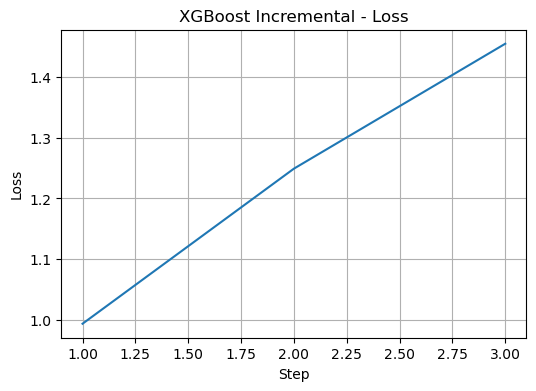

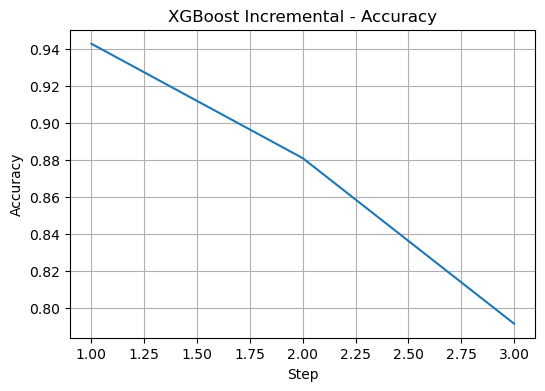

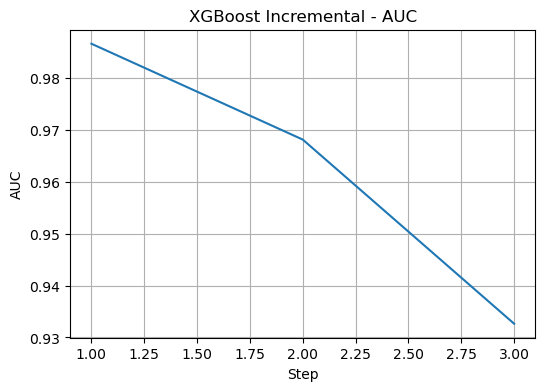

In [1]:
# ===== INCRE SGDOCSVM =====
import os, sys
from pathlib import Path

import pandas as pd 
import dask.dataframe as dd

# ----- THƯ VIỆN XỬ LÝ CHÍNH
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss
)


import torch
import torch.nn as nn

# ----- CÁC THƯ VIỆN HỖ TRỢ -----
import hashlib  
import ipaddress
import json
import glob
import gc
import pickle
import tempfile

# ----- THƯ VIỆN PLT -----
import matplotlib.pyplot as plt


# Model
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import NearestNeighbors
import xgboost as xgb

# ---------------- CONFIG -----------------
dir_in = [f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}.parquet" for i in range(0, 3)]
dir_in_train = [f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}_train.parquet" for i in range(0, 3)]
dir_in_test = [f"C:/Users/hoang/Documents/Dataset_KLTN/ciciot2023_extracted/merge-processed/Incremental_1.3/session{i}_test.parquet" for i in range(0, 3)]

gc.collect()
QUERY_N = 200          # số mẫu được query mỗi session (n trong paper)
K_NEIGHBORS = 100      # KNN outlier scoring
CLASS_WEIGHTS = {0:1.0, 1:10.0}   # normal=1, attack=10
RANDOM_STATE = 42
# -----------------------------------------


# ====== FUNCTION =====
dtypes = {}    
with open('features.json') as json_file:
    data = json.load(json_file)
    for key, type in data.items():
        if type == "int8":
            dtypes[key]= np.int8
        elif type == "float32":
            dtypes[key] = np.float32
    json_file.close()

print(dtypes)

def astype(df):
    for key, type in df.dtypes.items():
        # print(f"Key: {key} \t {type}")
        if type == "int8":
            df[key] = df[key].astype(np.int8)
        elif type == "float32":
            df[key] = df[key].astype(np.float32)
            
    return df
# def load_df(path):
#     if path.endswith(".parquet"):
#         return pd.read_parquet(path)
#     return pd.read_csv(path)

# def preprocess(df, feature_cols, scaler=None):
#     df = df.dropna().copy()
#     X = df[feature_cols].values

#     if scaler is None:
#         scaler = StandardScaler()
#         X = scaler.fit_transform(X)
#     else:
#         X = scaler.transform(X)

#     y = df["label"].values
#     return X, y, scaler

def outlierness_scores(X, k=K_NEIGHBORS):
    k = min(k, X.shape[0]-1)
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    return distances[:, -1]

def uncertainty_from_proba(probas):
    return 1 - np.max(probas, axis=1)

def query_function(X, probas, out_scores, n=QUERY_N):
    half = n // 2
    idx_out = np.argsort(-out_scores)[:half]
    uncert = uncertainty_from_proba(probas)
    idx_unc = np.argsort(-uncert)[:half]
    idx = np.unique(np.concatenate([idx_out, idx_unc]))

    if len(idx) < n:
        need = n - len(idx)
        remaining = [i for i in np.argsort(-uncert) if i not in idx]
        idx = np.concatenate([idx, remaining[:need]])

    return idx.astype(int)

def train_xgb(X_train, y_train):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": 0.1,
        "max_depth": 6,
        "seed": RANDOM_STATE,
        "verbosity": 0
    }
    weights = np.array([CLASS_WEIGHTS[int(y)] for y in y_train])
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
    bst = xgb.train(params, dtrain, num_boost_round=100)
    return bst

def predict_proba_xgb(bst, X):
    d = xgb.DMatrix(X)
    preds = bst.predict(d)
    return np.vstack([1 - preds, preds]).T

# ================= MAIN PIPELINE ==================

def run_incremental_AL(train_files, test_files):
    
    # ---- Load all sessions ----
    df_train = pd.read_parquet(train_files[0])
    df_train = astype(df_train)
    X_train = df_train.drop(["Label", "Binary Label"], axis=1)
    y_train = df_train["Label"]

    # ---- Preprocess session 0 + train initial model ----
    # X0, y0, scaler = preprocess(df0, feature_cols)
    print(f"[INFO] Training initial model on Session 0: {X_train.shape[0]} samples")
    
    model = train_xgb(X_train, y_train)
    
    del df_train, X_train, y_train
    gc.collect()

    # ---- Evaluate initial ----
    df_test = pd.read_parquet(test_files[0])
    df_test = astype(df_test)
    
    X_test = df_test.drop(["Label", "Binary Label"], axis=1)
    y_test = df_train["Label"]
    
    p_test = predict_proba_xgb(model, X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    print(f"[AUC] After Session 0: {auc:.4f}")
    
    del df_test, X_test, y_test
    gc.collect()
    
    # ---------- SESSION 1 ----------
    df_train = pd.read_parquet(train_files[1])
    df_train = astype(df_train)
    X1 = df_train.drop(["Label", "Binary Label"], axis=1)
    y1 = df_train["Label"]
    print(f"\n[INFO] Active learning on Session 1: {df_train.shape[0]} samples")

    probas1 = predict_proba_xgb(model, X1)
    out1 = outlierness_scores(X1)

    idx = query_function(X1, probas1, out1)

    # Add queried samples to pool
    pool_X = np.vstack([pool_X, X1[idx]])
    pool_y = np.concatenate([pool_y, y1[idx]])

    print(f"[INFO] Added {len(idx)} labeled samples from Session 1")
    model = train_xgb(pool_X, pool_y)
    
    
    df_test = pd.read_parquet(test_files[1])
    df_test = astype(df_test)
    
    X_test = df_test.drop(["Label", "Binary Label"], axis=1)
    y_test = df_train["Label"]
    
    p_test = predict_proba_xgb(model, X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    print(f"[AUC] After Session 1: {auc:.4f}")

    del X1, y1, df_train, df_test, X_test, y_test
    gc.collect()
    
    # ---------- SESSION 2 ----------
    
    df2 = pd.read_parquet(train_files[1])
    df2 = astype(df_train)
    X2 = df_train.drop(["Label", "Binary Label"], axis=1)
    y2 = df_train["Label"]
    
    print(f"\n[INFO] Active learning on Session 2: {df2.shape[0]} samples")

    probas2 = predict_proba_xgb(model, X2)
    out2 = outlierness_scores(X2)

    idx = query_function(X2, probas2, out2)

    # Add queried samples
    pool_X = np.vstack([pool_X, X2[idx]])
    pool_y = np.concatenate([pool_y, y2[idx]])

    print(f"[INFO] Added {len(idx)} labeled samples from Session 2")
    model = train_xgb(pool_X, pool_y)

    p_test = predict_proba_xgb(model, X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    print(f"[AUC] After Session 2: {auc:.4f}")

    return model

def incre_xgboost(train_files: str,  test_files):
    
    history = {"loss": [], "acc": [], "auc": []}
    models = []
    
    for index, filepath in enumerate(train_files):
        df_train =  pd.read_parquet(filepath)
        df_train = astype(df_train)
        
        numClasses = len(df_train["Label"].value_counts())
    
        trainX = df_train.drop(["Label", "Binary Label"], axis =1)
        trainy = df_train["Label"]
        
        trainD = xgb.DMatrix(trainX, label=trainy)
        
        del trainX, trainy, df_train
        gc.collect()
        
        df_test = pd.read_parquet(test_files[index])
        df_test =astype(df_test)
        
        testX = df_test.drop(["Label", "Binary Label"], axis =1)
        testy = df_test["Label"]
        
        testD = xgb.DMatrix(testX)

        del testX, df_test
        gc.collect()
        
        print(f"\n=== Session {index} Training ===")
        if index == 0:
            params = {
            'objective': 'multi:softprob',      # hoặc reg:squarederror nếu regression / binary:logistic / multi:softmax
            'num_class': numClasses,
            'eval_metric': 'auc',                # hoặc rmse 
            'eta': 0.001,                         # giảm learning rate để tránh phá mô hình cũ
            'max_depth': 4,                      # tránh overfit session mới
            'subsample': 0.9,                    # giảm ảnh hưởng session mới
            'colsample_bytree': 0.9,             # giảm cập nhật lớn
            'tree_method': 'hist',               # ổn định hơn khi update
            'process_type': 'default'
            }
            model = xgb.train(params, trainD, num_boost_round =96) # , num_boost_round=20
        else:
            # params = {
            # 'objective': 'multi:softprob',      # hoặc reg:squarederror nếu regression / binary:logistic / multi:softmax
            # 'num_class': numClasses,
            # 'eval_metric': 'auc',                # hoặc rmse 
            # 'eta': 0.001,                         # giảm learning rate để tránh phá mô hình cũ
            # 'max_depth': 4,                      # tránh overfit session mới
            # 'subsample': 0.9,                    # giảm ảnh hưởng session mới
            # 'colsample_bytree': 0.9,             # giảm cập nhật lớn
            # 'tree_method': 'hist',               # ổn định hơn khi update
            # 'process_type': 'update',            # (QUAN TRỌNG) incremental-style
            # 'updater': 'updater',         
            # 'refresh_leaf': True                 # cập nhật leaf values thay vì cấu trúc
            # }
            params = {
            'objective': 'multi:softprob',      # hoặc reg:squarederror nếu regression / binary:logistic / multi:softmax
            'num_class': numClasses,
            'eval_metric': 'auc',                # hoặc rmse 
            'eta': 0.001,                         # giảm learning rate để tránh phá mô hình cũ
            'max_depth': 4,                      # tránh overfit session mới
            'subsample': 0.9,                    # giảm ảnh hưởng session mới
            'colsample_bytree': 0.9,             # giảm cập nhật lớn
            'tree_method': 'hist',               # ổn định hơn khi update
            'process_type': 'default'
            }
            model = xgb.train(params, trainD, num_boost_round=32,
                                xgb_model=models[index -1])
        
        models.append(model)
        
        # =====================================================
        #  PREDICT
        # =====================================================
        preds_proba = model.predict(testD)  # shape: (N, numClasses)
        preds = np.argmax(preds_proba, axis=1)

        # =====================================================
        #  METRICS
        # =====================================================
        loss = log_loss(testy, preds_proba)
        acc = accuracy_score(testy, preds)

        # AUC multi-class
        auc = roc_auc_score(
            pd.get_dummies(testy), 
            preds_proba,
            average="macro",
            multi_class="ovr"
        )
        
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["auc"].append(auc)
        
        del model
        gc.collect()
        
        print(f"Step {index+1}/{len(train_files)} | Loss={loss:.4f} | Acc={acc:.4f} | AUC={auc:.4f}")
    
    return history

if __name__ == "__main__":
    
    history = incre_xgboost(dir_in_train, dir_in_test)
    steps = np.arange(1, len(dir_in_test) +1)

    plt.figure(figsize=(6,4))
    plt.plot(steps, history["loss"])
    plt.title("XGBoost Incremental - Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(steps, history["acc"])
    plt.title("XGBoost Incremental - Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(steps, history["auc"])
    plt.title("XGBoost Incremental - AUC")
    plt.xlabel("Step")
    plt.ylabel("AUC")
    plt.grid()
    plt.show()